In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
import nvidia_smi
nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()


Total memory: 50962169856
Free memory: 33355661312
Used memory: 17606508544


In [4]:
print("Get memory info", torch.cuda.mem_get_info(device=None)) 
print("Get number of devices available: ", torch.cuda.device_count())

print("Memory stats about which device is free: ")

nvidia_smi.nvmlInit()


deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()



Get memory info (32180207616, 50962169856)
Get number of devices available:  3
Memory stats about which device is free: 
Device 0: b'Quadro RTX 8000', Memory : (63.15% free): 50962169856(total), 32180207616 (free), 18781962240 (used)
Device 1: b'Quadro RTX 8000', Memory : (68.84% free): 50962169856(total), 35081617408 (free), 15880552448 (used)
Device 2: b'Quadro RTX 8000', Memory : (68.89% free): 50962169856(total), 35106783232 (free), 15855386624 (used)
Current Device:   0


In [5]:
print("Current Device:  ", torch.cuda.current_device()) 
torch.cuda.set_device(2)
torch.cuda.empty_cache() 


Current Device:   2


In [6]:

unique_labels = [
    'circular reasoning', 
    'false dilemma',
  'ad populum',
     'ad hominem', 
     'fallacy of logic', 
     'equivocation', 
     'fallacy of extension', 
     'fallacy of relevance', 
     'fallacy of credibility', 
     'intentional', 
    'faulty generalization', 
    'false causality'
]


In [6]:

MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [7]:
class LogicalFallacy(Dataset):
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.text = dataset.source_article
        self.targets = dataset.label
        self.max_len = max_len
        #self.original_label = dataset.updated_label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        

        return {
            'sentence': text,
            
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
       # sfmax = torch.nn.functional.softmax(output)
       # return sfmax
        return output



In [14]:
val = []
def predict(loader, label, epochs=1):
    model = torch.load('../models/v3/sentence_prompts/'+label+'_trained_roberta.pt')
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_answers = [[[],[]], [[],[]]]
    for epoch in range(epochs):
        for steps, data in tqdm(enumerate(loader, 0)):
            sentence = data['sentence']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
        
            outputs = model.forward(ids, mask, token_type_ids)
            print(torch.max(outputs.data, dim=1))
            values, max_indices = torch.max(outputs.data, dim=1)
            #print(g)
            val.append(values.tolist())
        
            if epoch == epochs-1:
                 for i in range(len(targets)):
                    
                     test_answers[targets[i].item()][max_indices[i].item()].append([
                                                                        sentence[i], 
                                                                        targets[i].item(), 
                                                                        max_indices[i].item()
                                                                     ])
        
    return val
                                                                

       


In [15]:
def driver_code(label):
   
    test_df = pd.read_csv('../data/test_data/v2/'+label+'_test.csv')
    #test_df = test_df[test_df['cleaner_prompt'].notna()]
    #test_df = test_df[['argument', 'WA']] 
    #test_df = test_df[:50]
    
    test_set = LogicalFallacy(test_df, tokenizer, MAX_LEN)

    
    
    

    test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
    
    test_loader = DataLoader(test_set, **test_params)

    #print(test_loader)
    value = predict(test_loader, label)
    total_vals = [] 
    for arr in val: 
        for arr_in in arr:
            total_vals.append(arr_in)
    return total_vals



In [16]:
test_df = pd.read_csv('../data/IBM_arg_30k_test.csv')
dictionary = {}
for i in range(len(unique_labels)):
    
     dictionary[unique_labels[i]]= driver_code(unique_labels[i])
     break
dictionary.to_csv('../auxillary data/vals.csv')


    

0it [00:00, ?it/s]/nas/home/vprasann/anaconda3/envs/neuros/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:00, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:2! (when checking argument for argument index in method wrapper__index_select)

In [39]:
test_df = pd.read_csv('../data/IBM_arg_30k_test.csv')
test_df = test_df[:100]
g = test_df['argument'].to_list()

len(g)

100

In [168]:
c = driver_code('circular reasoning')
c

AttributeError: 'DataFrame' object has no attribute 'source_article'

In [91]:
import math
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

circular reasoning
false dilemma
ad populum
ad hominem
fallacy of logic
fallacy of extension
fallacy of relevance
fallacy of credibility
intentional
faulty generalization
false causality


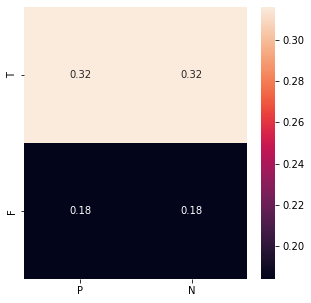

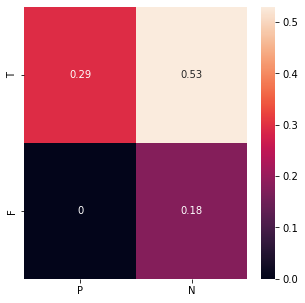

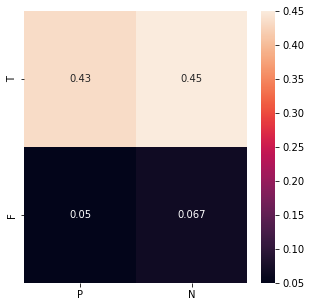

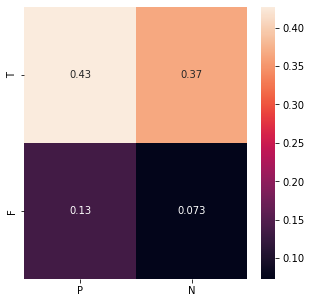

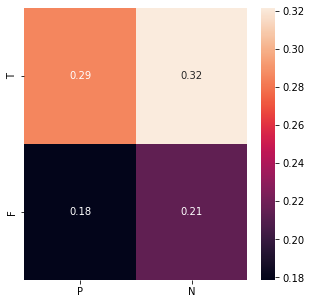

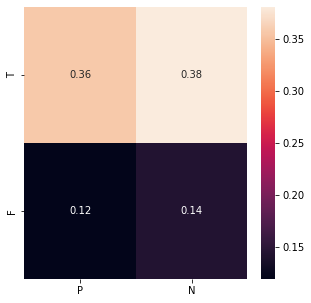

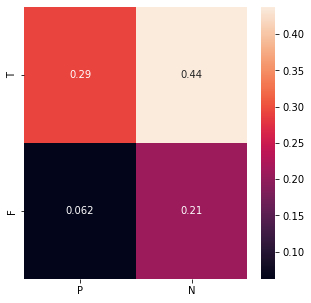

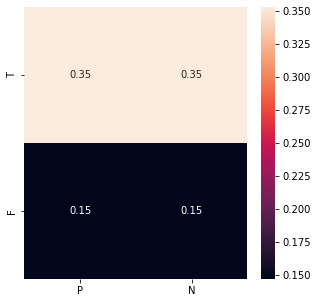

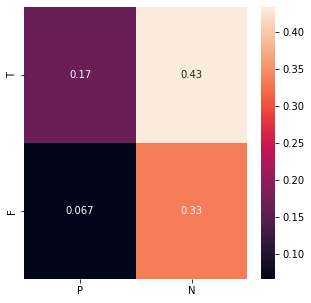

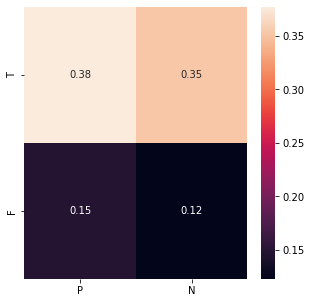

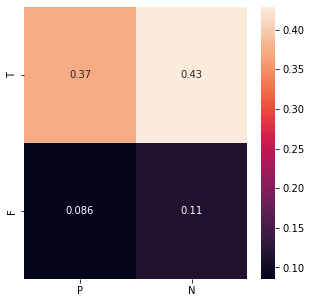

In [92]:
tp_list, tn_list, fp_list, fn_list = [], [], [], [] 
accuracy_list, precision_list, recall_list = [], [], [] 
for i in range(len(unique_labels)):
    print(unique_labels[i])
    test_df =  pd.read_csv('../data/test_data/v2/'+unique_labels[i]+'_test.csv')
    len_num = len(test_df)

    tp=len(test_answers_list[i][1][1])/len_num
    fn=len(test_answers_list[i][1][0])/len_num
    fp=len(test_answers_list[i][0][1])/len_num
    tn=len(test_answers_list[i][0][0])/len_num


    array_matrix = [[tp,tn], 
                    [fp,fn]]
    df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                    columns = ['P', 'N'])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)

    precision = truncate( tp / (tp + fp), 3) 
    recall = truncate( tp/ (tp + fn), 3)
    accuracy =truncate( tp+tn/(tp+tn+fp+fn), 3) 

    tp_list.append(truncate(tp,3)) 
    tn_list.append(truncate(tn, 3)) 
    fp_list.append(truncate(fp,3)) 
    fn_list.append(truncate(fn, 3))
    accuracy_list.append(accuracy) 
    recall_list.append(recall) 
    precision_list.append(precision) 

In [93]:
dictionary = {
    'fallacy class': unique_labels, 
    'accuracy': accuracy_list,
    'precision': precision_list, 
    'recall': recall_list, 
    'TP': tp_list, 
    'TN': tn_list,
    'FP':fp_list, 
    'FN':fn_list, 
    #'Classes for False Positive:': extract_classes
}
df = pd.DataFrame.from_dict(dictionary) 
df.to_csv (r'../results/v3/articles.csv', index = False, header=True) 



In [39]:
s = pd.read_csv('../data/train_data/v2/equivocation_train.csv')